In [ ]:
import os
import datetime as dt#デフォはUTCの国際基準時間
import pytz#日本時間に変換

import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import statsmodels.api as sm # version 0.8.0以上
from sklearn.preprocessing import  MinMaxScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_squared_error,r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras import regularizers
from keras.models import load_model
from keras import backend as K

from google.colab import files

In [ ]:
path = 'COVID-19'
if not os.path.exists(path):
  !git clone https://github.com/CSSEGISandData/COVID-19.git
else:
  print("Dude!! This file is already download")
#dataの更新は21：３０に行われる？

Dude!! This file is already download


In [ ]:
df = pd.read_csv('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df = df[df['Country/Region']=='Japan']
df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,9/18/20,9/19/20,9/20/20,9/21/20,9/22/20,9/23/20,9/24/20,9/25/20,9/26/20,9/27/20,9/28/20,9/29/20,9/30/20,10/1/20,10/2/20,10/3/20,10/4/20,10/5/20,10/6/20,10/7/20,10/8/20,10/9/20,10/10/20,10/11/20,10/12/20,10/13/20,10/14/20,10/15/20,10/16/20,10/17/20,10/18/20,10/19/20,10/20/20,10/21/20,10/22/20,10/23/20,10/24/20,10/25/20,10/26/20,10/27/20
151,NaN,Japan,36.204824,138.252924,2,2,2,2,4,4,7,7,11,15,20,20,20,22,23,23,23,24,24,26,27,28,33,43,54,60,67,79,85,95,112,137,149,160,173,192,...,78061,78662,79142,79462,79773,80009,80490,81054,81703,82186,82484,83022,83591,84244,84768,85345,85746,86027,86540,87039,87679,88267,88962,89400,89652,90153,90694,91402,92044,92670,93098,93408,93895,94515,95134,95868,96599,97095,97503,98146


In [ ]:
df = df.iloc[:,4:].copy()
data_at_japan = df.iloc[0,:]
data_at_japan.index = pd.to_datetime(data_at_japan.index)
print(data_at_japan)

2020-01-22        2
2020-01-23        2
2020-01-24        2
2020-01-25        2
2020-01-26        4
              ...  
2020-10-23    95868
2020-10-24    96599
2020-10-25    97095
2020-10-26    97503
2020-10-27    98146
Name: 151, Length: 280, dtype: int64


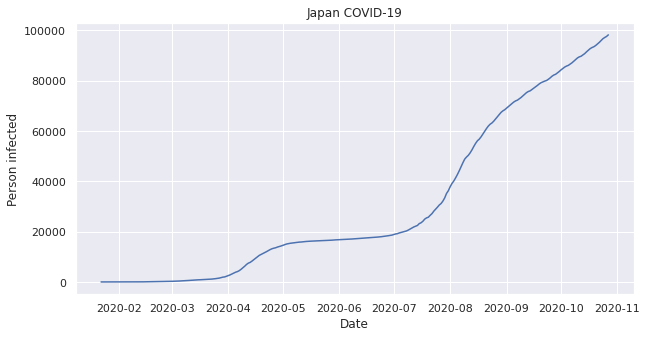

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(data_at_japan)
plt.title("Japan COVID-19")
plt.xlabel("Date")
plt.ylabel("Person infected")
plt.grid(True)
plt.show()

In [ ]:
data_at_japan_diff = data_at_japan - data_at_japan.shift(1) # 階差系列データの作成
data_at_japan_diff = data_at_japan_diff.dropna()
data_at_japan_diff

2020-01-23      0.0
2020-01-24      0.0
2020-01-25      0.0
2020-01-26      2.0
2020-01-27      0.0
              ...  
2020-10-23    734.0
2020-10-24    731.0
2020-10-25    496.0
2020-10-26    408.0
2020-10-27    643.0
Name: 151, Length: 279, dtype: float64

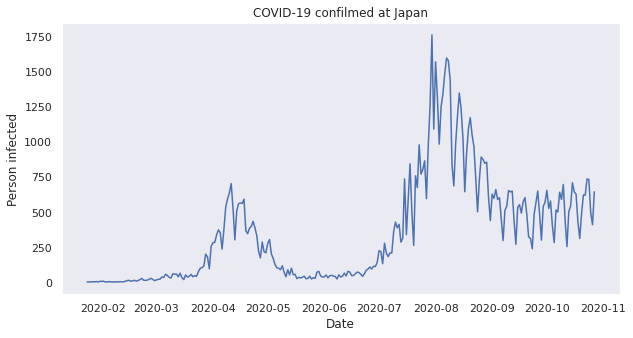

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(data_at_japan_diff)
plt.title('COVID-19 confilmed at Japan')
plt.xlabel('Date')
plt.ylabel('Person infected')
plt.grid()
plt.show()

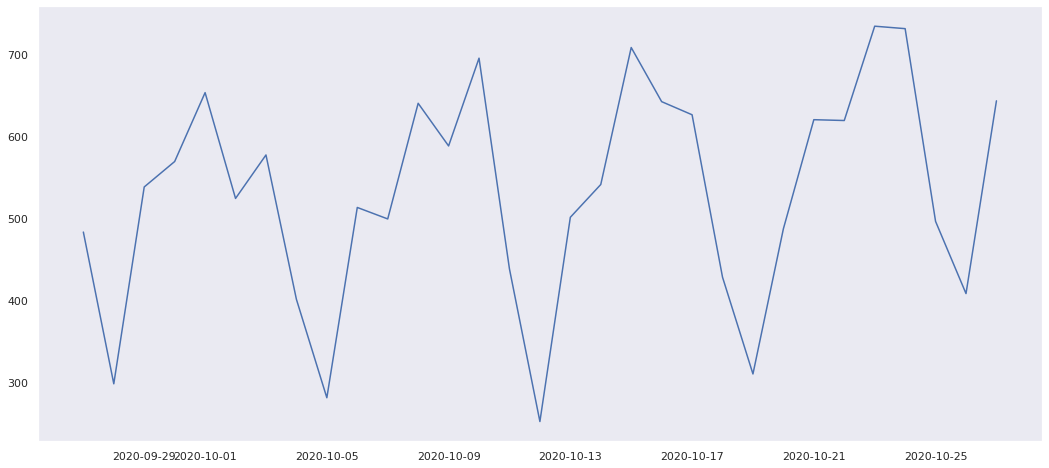

In [ ]:
hoge=data_at_japan_diff[-31:]
#print(hoge)
plt.figure(figsize=(18,8))
plt.plot(hoge)
plt.grid()
plt.show()

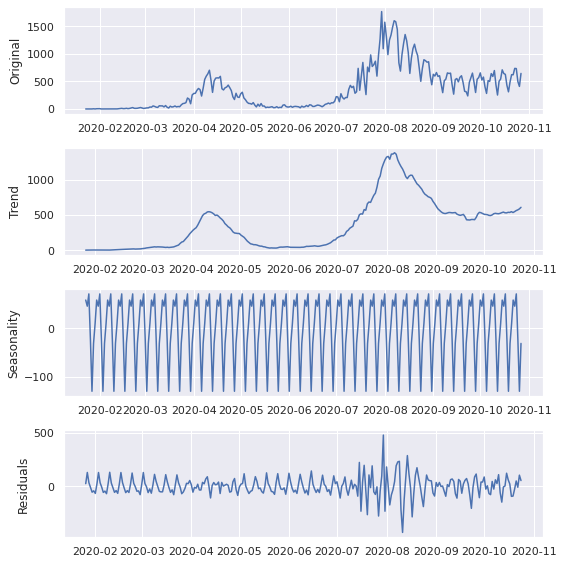

In [ ]:
res = sm.tsa.seasonal_decompose(data_at_japan_diff)#データを分解

original = data_at_japan_diff # オリジナルデータ
trend_original = res.trend # トレンドデータ
seasonal_original = res.seasonal # 季節性データ
residual = res.resid # 残差データ

plt.figure(figsize=(8, 8)) # グラフ描画枠作成、サイズ指定

# オリジナルデータのプロット
plt.subplot(411) # グラフ4行1列の1番目の位置（一番上）
plt.plot(original)
plt.ylabel('Original')

# trend データのプロット
plt.subplot(412) # グラフ4行1列の2番目の位置
plt.plot(trend_original)
plt.ylabel('Trend')

# seasonalデータ のプロット
plt.subplot(413) # グラフ4行1列の3番目の位置
plt.plot(seasonal_original)
plt.ylabel('Seasonality')

# residual データのプロット
plt.subplot(414) # グラフ4行1列の4番目の位置（一番下）
plt.plot(residual)
plt.ylabel('Residuals')

plt.tight_layout() # グラフの間隔を自動調整

In [ ]:
y = data_at_japan_diff.values.astype(float)
len(y)

279

In [ ]:
test_size = 7
train_original_data = y[:-test_size]#0から後ろから4個目までを取り出す。　つまり学習用のデータ(学習の範囲)は直近３日間前
test_original_data = y[-test_size:]#最後から３つを取り出す。　検証用データは直近３日間前

In [ ]:
def sequence_creator(input_data,window_size):#train_normalizedとwindow_sizeを渡し訓練データと正解ラベルを返す

    data, target = [], []
    data_len = len(input_data)
    for i in range(data_len - window_size):#data_lenのままだとwindowが配列を超えてしまう
        window_fr = input_data[i:i+window_size]#iを始点にwindow数取り出す
        correct_label = input_data[i+window_size:i+window_size+1]#index番号がi+windowの値を取り出す。つまりwindowの後にある正解ラベルを取り出す。
        data.append(window_fr)
        target.append(correct_label)

    re_data = np.array(data).reshape(len(data), window_size, 1)#kerasのRNNでは入力をサンプル数,時系列数(window数),入力層のニューロン数にする。　本来なら−１でなくlen(data)?
    re_target = np.array(target).reshape(len(target), 1)#入力と同じにする必要がある。

    return re_data, re_target

In [ ]:
scaler = MinMaxScaler(feature_range=(-1,1))#feature_rangeは引数に正規化変換後の最大値と最小値を決める。今回は−１から１で正規化
train_normalized = scaler.fit_transform(train_original_data.reshape(-1,1))#学習用データに正規化の適用　またskleranの入力形状に適用 合わせた行と１列

In [ ]:
window = 7#学習時のウィンドウサイズ

In [ ]:
study_data, correct_data  = sequence_creator(train_normalized, window)

In [ ]:
n_in_out = 1
n_hidden = 32#2の乗数 128#256 #512

def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

model = Sequential()
model.add(LSTM(n_hidden, batch_input_shape=(None, window, n_in_out), recurrent_activation='relu',kernel_initializer='he_normal',return_sequences=False))
# model.add(Dropout(0.2))
# model.add(LSTM(n_hidden, recurrent_activation='sigmoid',return_sequences=True))
# model.add(Dropout(0.2))
#model.add(LSTM(n_hidden,batch_input_shape=(None, window, n_in_out), recurrent_activation='sigmoid', return_sequences=False))#, kernel_regularizer=regularizers.l1(0.01)
model.add(Dropout(0.25))
model.add(Dense(n_in_out))
model.add(Activation("linear"))
optimizer = Adam(lr=0.01,  amsgrad=True)
model.compile(loss="mse", optimizer=optimizer,metrics=["mae",rmse])# optimizer="rmsprop"
print(model.summary())

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 32)                4352      
_________________________________________________________________
dropout_17 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 33        
_________________________________________________________________
activation_17 (Activation)   (None, 1)                 0         
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
#early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=1)
# 学習率を返す関数を用意する
def lr_schedul(epoch):
    x = 0.01
    if epoch >= 25:
        x = 0.005
    if epoch >= 50:
        x = 0.001
    if epoch >= 75:
        x = 0.0005
    return x


lr_decay = LearningRateScheduler(
    lr_schedul,
    # verbose=1で、更新メッセージ表示。0の場合は表示しない
    verbose=0,
)

epochs=200#400
history = model.fit(study_data, correct_data, batch_size=1, epochs=epochs, validation_split=0.1, verbose=1, callbacks=[lr_decay,])

Epoch 1/200
238/238 [==============================] - 2s 10ms/step - loss: 0.1641 - mae: 0.2629 - rmse: 0.2629 - val_loss: 0.0227 - val_mae: 0.1257 - val_rmse: 0.1257
Epoch 2/200
238/238 [==============================] - 2s 9ms/step - loss: 0.0430 - mae: 0.1599 - rmse: 0.1599 - val_loss: 0.0238 - val_mae: 0.1418 - val_rmse: 0.1418
Epoch 3/200
238/238 [==============================] - 2s 10ms/step - loss: 0.0522 - mae: 0.1624 - rmse: 0.1624 - val_loss: 0.0218 - val_mae: 0.1320 - val_rmse: 0.1320
Epoch 4/200
238/238 [==============================] - 2s 9ms/step - loss: 0.0485 - mae: 0.1553 - rmse: 0.1553 - val_loss: 0.0225 - val_mae: 0.1330 - val_rmse: 0.1330
Epoch 5/200
238/238 [==============================] - 2s 9ms/step - loss: 0.0370 - mae: 0.1444 - rmse: 0.1444 - val_loss: 0.0236 - val_mae: 0.1406 - val_rmse: 0.1406
Epoch 6/200
238/238 [==============================] - 2s 9ms/step - loss: 0.0364 - mae: 0.1387 - rmse: 0.1387 - val_loss: 0.0215 - val_mae: 0.1357 - val_rmse: 0.1

In [ ]:
# model.save('model.h5')
# files.download('model.h5')

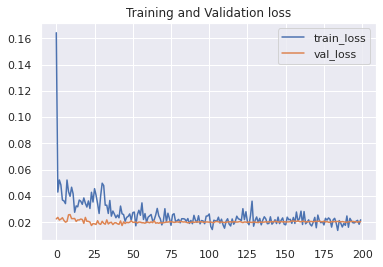

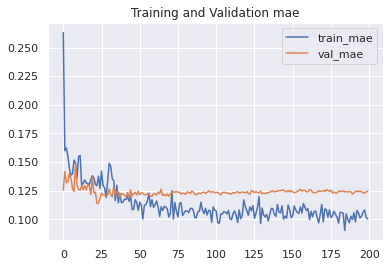

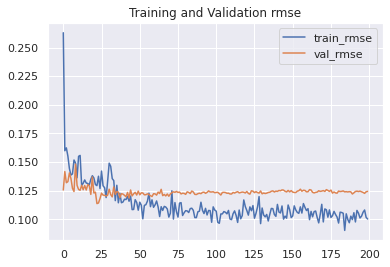

In [ ]:
# === 学習推移の可視化 ===
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(np.arange(len(train_loss)), train_loss, label="train_loss")
plt.plot(np.arange(len(val_loss)), val_loss, label="val_loss")
plt.title('Training and Validation loss')
plt.legend()
plt.show()

train_mae = history.history['mae']
val_mae = history.history['val_mae']

plt.plot(np.arange(len(train_mae)), train_mae, label="train_mae")
plt.plot(np.arange(len(val_mae)), val_mae, label="val_mae")
plt.title('Training and Validation mae')
#plt.ylim((0, 0.1))#add
plt.legend()
plt.show()

train_rmse = history.history['rmse']
val_rmse = history.history['val_rmse']

plt.plot(np.arange(len(train_loss)), train_rmse, label="train_rmse")
plt.plot(np.arange(len(val_loss)), val_rmse, label="val_rmse")
plt.title('Training and Validation rmse')
plt.legend()
plt.show()

In [ ]:
#training predictions
predicted_past_data = model.predict(study_data)
train_inverse= scaler.inverse_transform(predicted_past_data)

#test predictions
upcoming_future=7
predictions = train_normalized[-window:].tolist()
predictions = np.array(predictions).reshape(-1, window, 1)
#予測をfor文で
for i in range(upcoming_future):
  predicted_future = model.predict(predictions)
  with open("in_out.txt",mode="a", encoding= "utf-8") as f:
    f.write("input to model:" + str(predictions) )
    f.write("output from model:" + str(predicted_future) )
  predictions = predictions.tolist()
  predictions = np.append(predictions,predicted_future)
  predictions = predictions[-window:]
  predictions = np.array(predictions).reshape(-1, window, 1)

predictions_infected_pepole = scaler.inverse_transform(np.array(predictions).reshape(-1,1))
predictions_infected_pepole

array([[577.81424135],
       [521.41075027],
       [476.0602352 ],
       [420.12331051],
       [383.80506903],
       [370.19262064],
       [364.58458197]])

In [ ]:
x_all =np.arange('2020-01-23','2020-10-28', dtype='datetime64[D]').astype('datetime64[D]')
x_past_predict = np.arange('2020-01-30','2020-10-21', dtype='datetime64[D]').astype('datetime64[D]')#23-26
x_train = np.arange('2020-01-23','2020-10-21', dtype='datetime64[D]').astype('datetime64[D]')
x_test = np.arange('2020-10-21', '2020-10-28', dtype='datetime64[D]').astype('datetime64[D]')

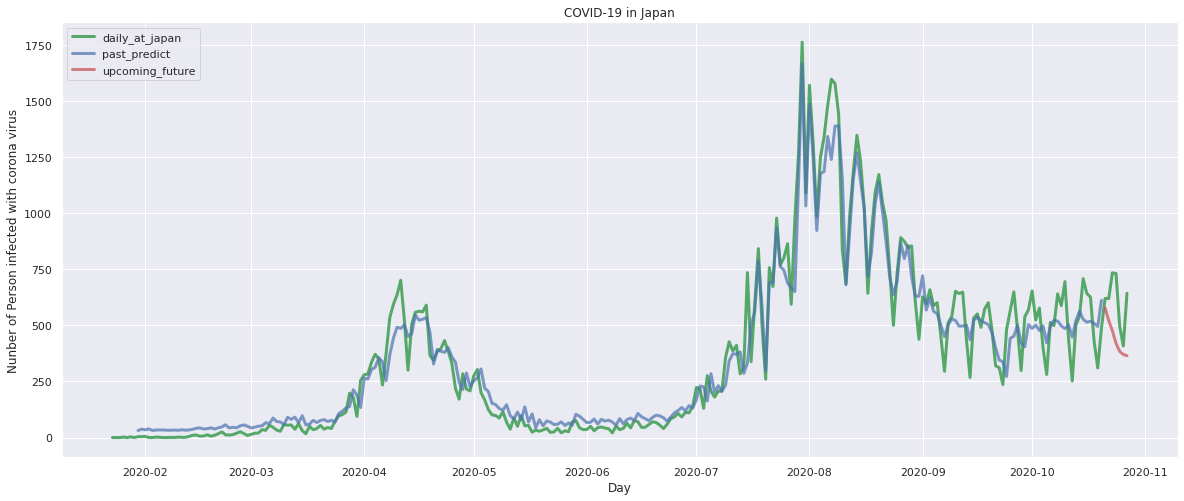

In [ ]:
sns.set()
COVID = plt.figure(figsize=(20,8))
plt.title("COVID-19 in Japan")
plt.grid(True)
plt.xlabel("Day")
plt.ylabel("Nunber of Person infected with corona virus")
plt.plot(x_all,data_at_japan_diff,'g',lw=3,label='daily_at_japan')
#plt.plot(x_train,train_original_data,label='train_data')
#plt.plot(x_test,test_original_data,label='test_data')
plt.plot(x_past_predict,train_inverse,color='b', ls='-',lw=3,alpha=0.7, label='past_predict')#+8かも
plt.plot(x_test, predictions_infected_pepole, 'r',lw=3,alpha=0.7,label='upcoming_future')
plt.legend(loc='upper left')
plt.show()

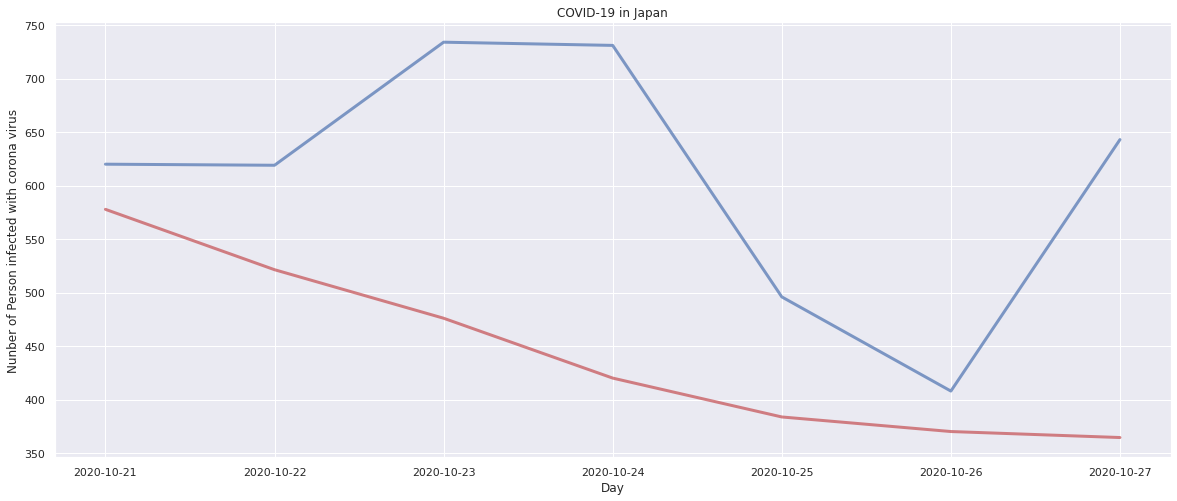

In [ ]:
sns.set()
COVID = plt.figure(figsize=(20,8))
plt.title("COVID-19 in Japan")
plt.grid(True)
plt.xlabel("Day")
plt.ylabel("Nunber of Person infected with corona virus")
plt.plot(x_test,test_original_data,color='b', ls='-',lw=3,alpha=0.7, label='past_predict')
plt.plot(x_test, predictions_infected_pepole, 'r',lw=3,alpha=0.7,label='upcoming_future')
plt.show()

In [ ]:
train_data = train_original_data[7:]
train_mae = mean_absolute_error(train_data, train_inverse)
train_mse = mean_squared_error(train_data, train_inverse)
train_rmse = np.sqrt(mean_squared_error(train_data, train_inverse))
train_r2 = r2_score(train_data, train_inverse)

test_mae = mean_absolute_error(test_original_data, predictions_infected_pepole)
test_mse = mean_squared_error(test_original_data, predictions_infected_pepole)
test_rmse = np.sqrt(mean_squared_error(test_original_data, predictions_infected_pepole))
test_r2 = r2_score(test_original_data, predictions_infected_pepole)

print('train_mae:'+str(train_mae))
print('train_mse:'+str(train_mse))
print('train_rmae:'+str(train_rmse))
print('train_r2:'+str(train_r2))
print('')
print('test_mae:'+str(test_mae))
print('test_mae:'+str(test_mse))
print('test_mae:'+str(test_rmse))
print('test_mae:'+str(test_r2))#r2 最も当てはまりの良い場合、1.0 となります (当てはまりの悪い場合、マイナスとなることもあります)

train_mae:60.798116338477946
train_mse:7267.850265597478
train_rmae:85.25168775805837
train_r2:0.9486477100590291

test_mae:162.42988443374634
test_mae:38001.82624233393
test_mae:194.94057105265168
test_mae:-2.1282582820511164
